In [9]:
gz_path = '/home/gorosa/redesNeuraisTeste/audio/dados/dataset_commands-002.gz'

In [10]:
import tensorflow as tf
import pathlib
import gzip
import shutil
import numpy as np

In [11]:
def le_arquivos(gz_path):
    extracted_path = '/tmp/dataset_commands'
    
    with gzip.open(gz_path, 'rb') as f_in:
        with open(extracted_path + '.tar', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    # Extrair o arquivo .tar resultante
    shutil.unpack_archive(extracted_path + '.tar', extracted_path)
    
    data_dir = pathlib.Path(extracted_path)
    
    all_audio_paths = list(data_dir.glob('*/**/*.wav'))
    all_labels = [path.parent.name for path in all_audio_paths]
    
    # Converter caminhos para strings
    all_audio_paths = [str(path) for path in all_audio_paths]
    
    return all_audio_paths, all_labels

In [12]:
all_audio_paths, all_labels = le_arquivos(gz_path)

In [13]:
np.unique(all_labels)

array(['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog',
       'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
       'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
       'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'], dtype='<U18')

In [14]:
np.unique(all_labels).shape

(36,)

Carregando o audio

In [15]:
import matplotlib.pyplot as plt

In [16]:
example_audio_path = all_audio_paths[0]

In [17]:
audio_binary = tf.io.read_file(example_audio_path)
audio, _ = tf.audio.decode_wav(audio_binary)
audio = tf.squeeze(audio, axis=-1)

I0000 00:00:1731456131.056013 2170978 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731456131.080916 2170978 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731456131.081063 2170978 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731456131.083225 2170978 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

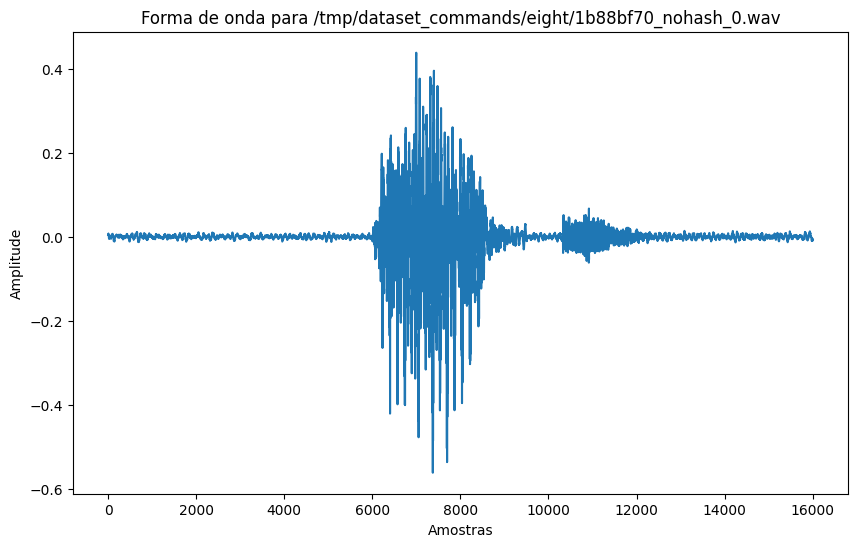

In [18]:
# Plotar a forma de onda
plt.figure(figsize=(10, 6))
plt.plot(audio.numpy())
plt.title(f'Forma de onda para {example_audio_path}')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

Precisamos padronizar os arquivos para entrar na rede neural, devido à variação de como os usuários vão gravar

In [19]:
from scipy.signal import resample

In [20]:
def load_and_process_audio(filename, max_length=16000):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav
    
    wav = tf.py_function(scipy_resample, [wav, sample_rate], tf.float32)
    
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, 'CONSTANT')
        
    # Adiciona a dimensão para corresponder a (16000, 1)
    return tf.expand_dims(wav, -1)

In [21]:
def process_path(file_path, label):
    audio = load_and_process_audio(file_path)
    return audio, label

In [22]:
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)

    audio_label_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return audio_label_ds.map(process_path,num_parallel_calls=tf.data.AUTOTUNE)

Vamos agora separar os dados

In [23]:
def prepare_for_training(ds, batch_size = 32, shuffle_buffer_size = 1000):
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size = tf.data.AUTOTUNE)
    return ds

In [24]:
# Processando as classes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_audio_paths, all_labels_encoded, test_size = 0.02, random_state=42, stratify=all_labels_encoded
)

In [27]:
train_dataset = paths_and_labels_to_dataset(train_paths, train_labels)

In [ ]:
label_list = []
for element in train_dataset:
    label = element[1]
    label_list.append(label.numpy())
num_labels = len(np.unique(label_list))

2024-11-12 21:09:00.311717: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
num_labels

36

In [78]:
val_dataset = paths_and_labels_to_dataset(val_paths, val_labels)

In [79]:
train_dataset = prepare_for_training(train_dataset)
test_dataset = prepare_for_training(val_dataset)

## Rede Neural

In [80]:
from tensorflow.keras import layers, models 

In [81]:
model_time_domain = models.Sequential([
    layers.Input(shape=(16000, 1)),
    
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(256, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(36, activation='softmax')
])


In [82]:
model_time_domain.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [83]:
history = model_time_domain.fit(train_dataset,
                                epochs = 10,
                                validation_data = val_dataset)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=True
  • mask=None

In [ ]:
def plot_history(history):
    # Resumo do histórico de precisão
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend(loc='lower right')

    # Resumo do histórico de perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_history(history)

NameError: name 'plot_history' is not defined